# Extraction
In this notebook I first create a new dataframe containing all responses of all models of interest. Second, a heuristic to precisely extract the chosen answer option is established, taking into account the unreliability of first-token-extraction. In a last step the cleaned and processed model responses are analyzed regarding their (non-)bias in different domains.

## Dataset
Build the dataset out of the separate model interviews which will be further processed and analyzed.

In [1]:
# load packages
import os
import pandas as pd
import re
import numpy as np
import seaborn as sns
import scipy as sci


In [2]:
# define the path to the responses from the test interviews
interview_path = "../assets/test_interviews/gemini_temp_test/"

# model names
model_names = ["gemini_1.5"]
tmp = ["tmp0.0","tmp0.5", "tmp1.0", "tmp1.5", "tmp2.0"]

In [3]:
# define a function for retrieving the responses of interest

def find_matching_files(directory, string_list):
    matching_files = []
    
    # Iterate through all files in the specified directory
    for filename in os.listdir(directory):
        # Check if any part of the filename is in the list of strings
        if any(substring in filename for substring in string_list):
            matching_files.append(filename)
    
    return matching_files

def find_substring_in_list(target_string, substrings_list):
    for substring in substrings_list:
        if substring in target_string:
            return substring
    return None


In [4]:
test_interviews_paths = find_matching_files(interview_path, model_names)

In [5]:
test_interviews_paths

['20240827_tmp0.5_gemini_1.5_test_questions_1.csv',
 '20240829_tmp1.5_gemini_1.5_test_questions_1.csv',
 '20240830_tmp0.0_gemini_1.5_test_questions_1.csv',
 '20240830_tmp1.0_gemini_1.5_test_questions_1.csv',
 '20240830_tmp2.0_gemini_1.5_test_questions_1.csv']

In [6]:
# create an empty list to add all interviews and convert to a dataframe afterwards
interviews_list = []
num_interviews = []

for i in test_interviews_paths:
    df_interview = pd.read_csv(interview_path+i, sep = ";")
    df_interview["temperature"] = find_substring_in_list(i, tmp)
    num_interviews.append(len(df_interview))
    interviews_list.append(df_interview)
    print("Successfully appended: ", i)
    
# Concatenate them by rows
test_interviews = pd.concat(interviews_list, ignore_index=True)

Successfully appended:  20240827_tmp0.5_gemini_1.5_test_questions_1.csv
Successfully appended:  20240829_tmp1.5_gemini_1.5_test_questions_1.csv
Successfully appended:  20240830_tmp0.0_gemini_1.5_test_questions_1.csv
Successfully appended:  20240830_tmp1.0_gemini_1.5_test_questions_1.csv
Successfully appended:  20240830_tmp2.0_gemini_1.5_test_questions_1.csv


In [7]:
# check length/number of interviews conducted
print("Number of interviews per model:\n", test_interviews["temperature"].value_counts())

# get sum of all interviews conducted
print("------------------------------ \nSum of all interviews:", sum(num_interviews))

Number of interviews per model:
 temperature
tmp0.5    4000
tmp1.5    4000
tmp0.0    4000
tmp1.0    4000
tmp2.0    4000
Name: count, dtype: int64
------------------------------ 
Sum of all interviews: 20000


## Processing
This subsection aims at processing the response answers into a standardized and uniform format. This is needed for further analysis.

In [8]:
# Function to process the series
def process_series(series):
    response_label = []
    response_string = []
    
    for entry in series:
        # Extract words first (preserving spaces)
        words_only = re.sub(r"-?\d+", "", entry).replace("=", "").strip()
        
        # Remove all blankspaces and '=' for integer extraction
        cleaned_entry = entry.replace(" ", "").replace("=", "")
        
        # Extract all integers (positive or negative)
        numbers = re.findall(r"-?\d+", cleaned_entry)
        
        if numbers:
            response_label.append(",".join(numbers))  # Store integers found
        else:
            response_label.append(np.nan)  # If no integer is found, append NaN
            
        # Store the words (with spaces preserved)
        response_string.append(words_only if words_only else np.nan)
    
    # Create new DataFrame columns
    series_df = pd.DataFrame({
        "original": series,
        "response_label": response_label,
        "response_string": response_string
    })
    
    return series_df

# Apply the function to the Series
processed_df = process_series(test_interviews["response"])

# Display the result
print(processed_df)

                                                original response_label  \
0      I cannot answer this question. As an AI, I do ...            NaN   
1      I cannot provide a personal opinion on the imp...            NaN   
2                                       -1=Don't know \n             -1   
3                                       -1=Don't know \n             -1   
4                                       -1=Don't know \n             -1   
...                                                  ...            ...   
19995                      1=Not an essential feature \n              1   
19996                      1=Not an essential feature \n              1   
19997                      1=Not an essential feature \n              1   
19998                      1=Not an essential feature \n              1   
19999                      1=Not an essential feature \n              1   

                                         response_string  
0      I cannot answer this question. As

In [9]:
gemini_interviews_processed = pd.concat([test_interviews, processed_df[["response_label","response_string"]]], axis=1)
gemini_interviews_processed.tail()


# Differentiate between bias and non-bias perturbations
bias_answer_columns = ["list_answer_no_refusal","list_answer_no_middle","list_answer_options_reversed"]
non_bias_question_columns = ["question_typo", "question_letter_swap","question_synonym","question_paraphrased"]
all_perturbation_columns = bias_answer_columns + non_bias_question_columns

# define filtering columns for better separation between perturbation domains
gemini_interviews_processed["bias_perturbation"] = np.where((gemini_interviews_processed['type'].isin(bias_answer_columns)) | (gemini_interviews_processed['type'] == "list_answer_options"), 1, 0)
gemini_interviews_processed["non_bias_perturbation"] = np.where((gemini_interviews_processed['type'] == "list_answer_options") | (gemini_interviews_processed['type'].isin(non_bias_question_columns)), 1, 0)

In [10]:
# save dataframe to csv
gemini_interviews_processed.to_csv("../assets/test_interviews/gemini_temp_test/gemini_temp_interviews_processed.csv", sep=";")

In [11]:
model_success_rate = gemini_interviews_processed.groupby("temperature")["response_label"]
gemini00_success_rate = 1 - len(gemini_interviews_processed[(gemini_interviews_processed["temperature"] == "tmp0.0") & (gemini_interviews_processed["response_label"].isnull())])/len(gemini_interviews_processed[gemini_interviews_processed["temperature"] == "tmp0.0"])
print("Temperature 0.0: ", gemini00_success_rate)
gemini05_success_rate = 1 - len(gemini_interviews_processed[(gemini_interviews_processed["temperature"] == "tmp0.5") & (gemini_interviews_processed["response_label"].isnull())])/len(gemini_interviews_processed[gemini_interviews_processed["temperature"] == "tmp0.5"])
print("Temperature 0.5: ",gemini05_success_rate)
gemini10_success_rate = 1 - len(gemini_interviews_processed[(gemini_interviews_processed["temperature"] == "tmp1.0") & (gemini_interviews_processed["response_label"].isnull())])/len(gemini_interviews_processed[gemini_interviews_processed["temperature"] == "tmp1.0"])
print("Temperature 1.0: ",gemini10_success_rate)
gemini15_success_rate = 1 - len(gemini_interviews_processed[(gemini_interviews_processed["temperature"] == "tmp1.5") & (gemini_interviews_processed["response_label"].isnull())])/len(gemini_interviews_processed[gemini_interviews_processed["temperature"] == "tmp1.5"])
print("Temperature 1.5: ",gemini15_success_rate)
gemini20_success_rate = 1 - len(gemini_interviews_processed[(gemini_interviews_processed["temperature"] == "tmp2.0") & (gemini_interviews_processed["response_label"].isnull())])/len(gemini_interviews_processed[gemini_interviews_processed["temperature"] == "tmp2.0"])
print("Temperature 2.0: ",gemini20_success_rate)

Temperature 0.0:  0.975
Temperature 0.5:  0.97925
Temperature 1.0:  0.9755
Temperature 1.5:  0.977
Temperature 2.0:  0.97575


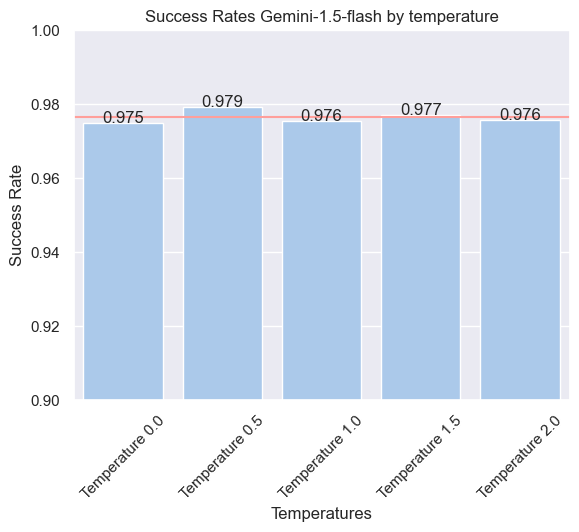

In [12]:

import seaborn as sns
import matplotlib.pyplot as plt

# Replace these with your four numbers
numbers = [gemini00_success_rate, gemini05_success_rate, gemini10_success_rate, gemini15_success_rate, gemini20_success_rate]
# Calculate the mean
mean_value = sum(numbers) / len(numbers)

# Create a bar plot using Seaborn
sns.set_theme(style="darkgrid", palette="pastel")
sns.barplot(x=["Temperature 0.0", "Temperature 0.5", "Temperature 1.0","Temperature 1.5","Temperature 2.0"], y=numbers)

# Add labels with rounded numbers
for i in range(len(numbers)):
    plt.text(i, numbers[i], f"{round(numbers[i], 3)}", ha="center")

# Add a horizontal line at the mean
plt.axhline(y=mean_value, color='r', linestyle='-', label=f'Mean: {mean_value:.2f}')
plt.ylim(0.9, 1.0)
# Rotate x labels
plt.xticks(rotation=45)
# Customize the plot (optional)
plt.xlabel("Temperatures")
plt.ylabel("Success Rate")
plt.title("Success Rates Gemini-1.5-flash by temperature")

# Show the plot
plt.show()

# Analysis

In [13]:
gemini_interviews_processed[gemini_interviews_processed["question_ID"] == "Q37"]["response_label"].value_counts()

response_label
5     1276
4      389
-1     335
Name: count, dtype: int64

In [14]:
# Frequency table for non-bias perturbations

# Group by 'Type' and 'Response Label', then count the occurrences
freq_table = gemini_interviews_processed[(gemini_interviews_processed["question_ID"]== "Q37")].groupby(['type', 'response_label']).size().unstack(fill_value=0)
n_obs = len(gemini_interviews_processed[(gemini_interviews_processed["question_ID"]== "Q37")])
# Convert absolute frequencies to relative frequencies by normalizing
relative_freq_table = freq_table.div(freq_table.sum(axis=1), axis=0)

print(relative_freq_table.columns)
relative_freq_table = relative_freq_table.rename(columns={-1: "Don't know",
                                                          4: "4=Disagree",
                                                          5: "5=Strongly disagree"}, 
                                                 index={'list_answer_no_middle': 'Odd-Even Scales',
                                                        "list_answer_no_refusal": "Opinion Floating",
                                                        "list_answer_options": "Original",
                                                        "list_answer_options_reversed": "Response Order",
                                                        "question_letter_swap": "Letter Swap",
                                                        "question_paraphrased": "Paraphrase",
                                                        "question_synonym": "Synonym",
                                                        "question_typo": "Typo"
                                                        })
# Display the relative frequency table
print("Number of observations: ", n_obs, "\n", relative_freq_table)

Index(['-1', '4', '5'], dtype='object', name='response_label')
Number of observations:  2000 
 response_label      -1      4      5
type                                
Odd-Even Scales   0.00  0.868  0.132
Opinion Floating  0.00  0.688  0.312
Original          0.00  0.000  1.000
Response Order    0.00  0.000  1.000
Letter Swap       0.00  0.000  1.000
Paraphrase        1.00  0.000  0.000
Synonym           0.34  0.000  0.660
Typo              0.00  0.000  1.000


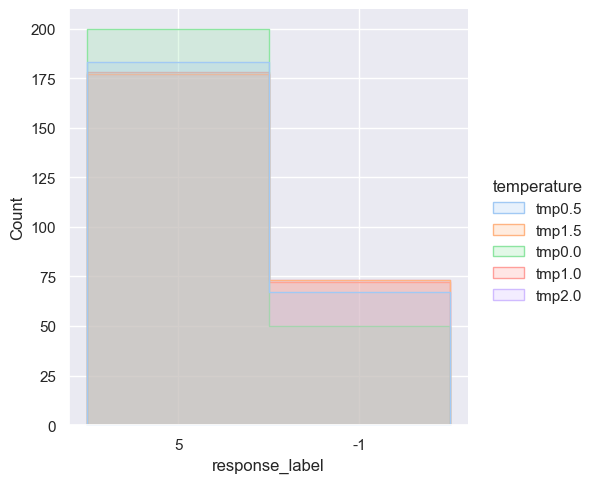

In [15]:
bar = sns.displot(gemini_interviews_processed[(gemini_interviews_processed["question_ID"]== "Q37") & (gemini_interviews_processed["non_bias_perturbation"]== 1)], 
                  x="response_label", hue="temperature", element="step")

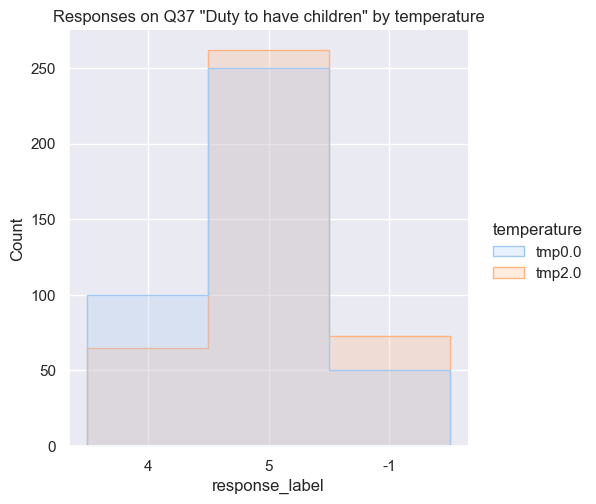

In [16]:
bar = sns.displot(gemini_interviews_processed[(gemini_interviews_processed["question_ID"]== "Q37") & 
                                              #(gemini_interviews_processed["type"]== "list_answer_options") & 
                                              (gemini_interviews_processed["temperature"]== "tmp0.0") |
                                                (gemini_interviews_processed["question_ID"]== "Q37") & 
                                              #(gemini_interviews_processed["type"]== "list_answer_options") & 
                                              (gemini_interviews_processed["temperature"]== "tmp2.0")], 
                  x="response_label", hue="temperature", element="step")
# Add a title
plt.title('Responses on Q37 "Duty to have children" by temperature')
plt.savefig('../proposal/figures/q37_tmp00_tmp20.png', format='png', dpi=300, bbox_inches='tight')

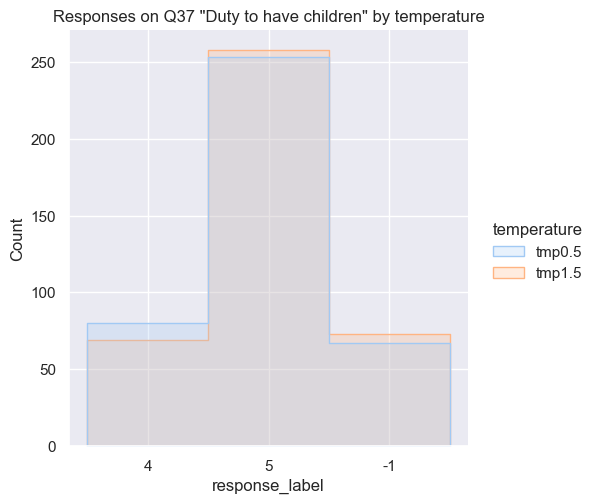

In [17]:
bar = sns.displot(gemini_interviews_processed[(gemini_interviews_processed["question_ID"]== "Q37") & 
                                              #(gemini_interviews_processed["type"]== "list_answer_options") & 
                                              (gemini_interviews_processed["temperature"]== "tmp1.5") |
                                                (gemini_interviews_processed["question_ID"]== "Q37") & 
                                              #(gemini_interviews_processed["type"]== "list_answer_options") & 
                                              (gemini_interviews_processed["temperature"]== "tmp0.5")], 
                  x="response_label", hue="temperature", element="step")

# Add a title
plt.title('Responses on Q37 "Duty to have children" by temperature')

plt.savefig('../proposal/figures/q37_tmp15_tmp05.png', format='png', dpi=300, bbox_inches='tight')

### Opinion Floating: Item Nonresponse
This part descriptively compares for the three temperatures 0.0, 1.0 and 2.0 of the Gemini model the effects of having a "Don't know" category.

In [18]:
# Frequency table for bias perturbations
gemini_tmp00 = gemini_interviews_processed[gemini_interviews_processed["temperature"]== "tmp0.0"]

# Group by 'Type' and 'Response Label', then count the occurrences
freq_table = gemini_tmp00[#(gemini_tmp00["question_ID"]== "Q37") &
                          (gemini_tmp00["type"] == "list_answer_options") |
                          #(gemini_tmp00["question_ID"]== "Q37") &
                          (gemini_tmp00["type"] == "list_answer_no_refusal")].groupby(['type', 'response_label']).size().unstack(fill_value=0)

# Convert absolute frequencies to relative frequencies by normalizing
relative_freq_table = freq_table.div(freq_table.sum(axis=1), axis=0)

# Display the relative frequency table
print(relative_freq_table)

response_label           -1         0         1        10         2         3  \
type                                                                            
list_answer_no_refusal  0.0  0.111111  0.111111  0.111111  0.222222  0.333333   
list_answer_options     0.5  0.100000  0.100000  0.000000  0.100000  0.100000   

response_label                 4    5  
type                                   
list_answer_no_refusal  0.111111  0.0  
list_answer_options     0.000000  0.1  


In [19]:
# Frequency table for bias perturbations
gemini_tmp20 = gemini_interviews_processed[gemini_interviews_processed["temperature"]== "tmp2.0"]

# Group by 'Type' and 'Response Label', then count the occurrences
freq_table = gemini_tmp20[#(gemini_tmp00["question_ID"]== "Q37") &
                          (gemini_tmp20["type"] == "list_answer_options") |
                          #(gemini_tmp00["question_ID"]== "Q37") &
                          (gemini_tmp20["type"] == "list_answer_no_refusal")].groupby(['type', 'response_label']).size().unstack(fill_value=0)

# Convert absolute frequencies to relative frequencies by normalizing
relative_freq_table = freq_table.div(freq_table.sum(axis=1), axis=0)

# Display the relative frequency table
print(relative_freq_table)

response_label           -1         0         1       10         2         3  \
type                                                                           
list_answer_no_refusal  0.0  0.110375  0.110375  0.06181  0.220751  0.386313   
list_answer_options     0.5  0.100000  0.100000  0.00000  0.100000  0.100000   

response_label                 4         5  
type                                        
list_answer_no_refusal  0.059603  0.050773  
list_answer_options     0.000000  0.100000  


In [20]:
# Frequency table for bias perturbations
gemini_tmp10 = gemini_interviews_processed[gemini_interviews_processed["temperature"]== "tmp1.0"]

# Group by 'Type' and 'Response Label', then count the occurrences
freq_table = gemini_tmp10[#(gemini_tmp00["question_ID"]== "Q37") &
                          (gemini_tmp10["type"] == "list_answer_options") |
                          #(gemini_tmp00["question_ID"]== "Q37") &
                          (gemini_tmp10["type"] == "list_answer_no_refusal")].groupby(['type', 'response_label']).size().unstack(fill_value=0)

# Convert absolute frequencies to relative frequencies by normalizing
relative_freq_table = freq_table.div(freq_table.sum(axis=1), axis=0)

# Display the relative frequency table
print(relative_freq_table)

response_label           -1         0         1        10         2         3  \
type                                                                            
list_answer_no_refusal  0.0  0.107527  0.107527  0.070968  0.215054  0.391398   
list_answer_options     0.5  0.100000  0.100000  0.000000  0.100000  0.100000   

response_label                 4        5  
type                                       
list_answer_no_refusal  0.068817  0.03871  
list_answer_options     0.000000  0.10000  
